# Preliminary Importing

In [391]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from collections import Counter
from string import punctuation

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
(second person) You and your and yourself and yours
(first person plural) we, us, our
vs
(first person singular) I and me and my and myself and mine
Overall most frequent words
What Proper Pronouns are used and when?

In [268]:
full_music = pd.read_csv("Billboard100(1950-2018).csv") #saved csv file from Google Sheets with lyrics added to web-scrapped data
pd.to_numeric(full_music["Year"])
music = full_music.loc[full_music["Year"]%10 == 0] #Get every 5
music = music[music["Position"] == "1"]
music = music.reset_index(drop=True)
print(music.shape)
music

(7, 5)


,Position,Song,Artist,Year,Lyrics
0,1,"""Goodnight Irene""",Gordon Jenkins & The Weavers,1950,"Irene, goodnight\nIrene, goodnight\nGoodnight,..."
1,1,"""Theme from A Summer Place""",Percy Faith,1960,There's a summer place\nWhere it may rain or s...
2,1,"""Bridge Over Troubled Water""",Simon & Garfunkel,1970,"When you're weary, feeling small\nWhen tears a..."
3,1,"""Call Me""",Blondie,1980,"Color me your color, baby\nColor me your car\n..."
4,1,"""Hold On""",Wilson Phillips,1990,I know there's pain\nWhy do you lock yourself ...
5,1,"""Breathe""",Faith Hill,2000,I can feel the magic floating in the air\nBein...
6,1,"""Tik Tok""",Kesha,2010,Wake up in the morning feeling like P Diddy (H...


In [311]:
full_lyrics = music["Lyrics"]
music["Lyrics"] = full_lyrics
music["Word Count"] = [len(song.split()) for song in music["Lyrics"]]
music["Character Count"] = [len(song) for song in music["Lyrics"]]
lyrics_by_sentence = [sent_tokenize(song) for song in music["Lyrics"]] #save for later
music["Lyrics"] = [word_tokenize(song) for song in music["Lyrics"]]
#lyrics_by_sentence = each element's element is a sentence
#lyrics = each element's element is a word
music

AttributeError: 'list' object has no attribute 'split'

In [312]:
songs_pos = []
songs_freq = []
spec_freq = []
prp_freq = []
prpp_freq = []
personal_freq = []
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    songs_pos += [pos_tag(song)]
    songs_freq += [nltk.FreqDist([tag for (word, tag) in songs_pos[i]])]
    spec_freq += [songs_freq[i].freq("WDT") + songs_freq[i].freq("WP") + songs_freq[i].freq("WP$") + songs_freq[i].freq("WRB")]
    prp_freq += [songs_freq[i].freq("PRP")]
    prpp_freq += [songs_freq[i].freq("PRP$")]
    personal_freq += [songs_freq[i].freq("PRP") + songs_freq[i].freq("PRP$")]
music["Personal Frequency"] = personal_freq #frequency of personal pronouns and possessive personal pronouns

In [313]:
stop_words = set(stopwords.words('english')) 
music["Lyrics"] = [[w for w in song if not w in stop_words] for song in music["Lyrics"]] 

In [314]:
sid = SentimentIntensityAnalyzer()
sentiments = ["positive", "neutral", "negative"]
sentiment_summary = dict([("positive", []), ("neutral", []), ("negative", [])])
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    for key in sentiments:
        sentiment_summary[key] += [0]
    for sentence in song:
        sentiment_score = sid.polarity_scores(sentence)
        if sentiment_score["compound"] == 0.0:
            sentiment_summary["neutral"][i] += 1
        elif sentiment_score["compound"] > 0.0:
            sentiment_summary["positive"][i] += 1
        else:
            sentiment_summary["negative"][i] += 1
print(sentiment_summary)

{'positive': [6, 14, 13, 15, 11, 3, 22], 'neutral': [73, 33, 52, 123, 172, 103, 182], 'negative': [4, 1, 10, 0, 11, 1, 25]}


In [315]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [316]:
def lemmatize(word, tag):
    tag = get_wordnet_pos(tag)
    if tag:
        return lemmatizer.lemmatize(word, tag)
    else:
        return lemmatizer.lemmatize(word)

In [317]:
lemmatizer = WordNetLemmatizer()
lyrics = []
for i in np.arange(len(music)):
    song = music["Lyrics"][i]
    lyrics += [[lemmatize(word, tag) for (word, tag) in songs_pos[i]]]
music["Lyrics"] = lyrics

In [363]:
vectorizer = TfidfVectorizer()
lyrics_by_song = []
for i in np.arange(len(music)):
    lyrics_by_song += [" ".join(lyrics[i])]
tfidf = vectorizer.fit_transform(lyrics_by_song)
tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
common = []
for i in np.arange(len(music)):
    print("Most common words of", music["Song"][i], "are:")
    common += [tfidf.iloc[i].sort_values(ascending=False)]
    print(tfidf.iloc[i].sort_values(ascending=False).head(), "\n")
music["Common Words"] = common

Most common words of "Goodnight Irene" are:
irene        0.639858
goodnight    0.639858
my           0.129479
sometimes    0.119973
wife         0.119973
Name: 0, dtype: float64 

Most common words of "Theme from A Summer Place" are:
arm       0.454391
summer    0.312802
place     0.312802
your      0.229395
in        0.196624
Name: 1, dtype: float64 

Most common words of "Bridge Over Troubled Water" are:
will        0.378039
bridge      0.324033
troubled    0.324033
water       0.324033
like        0.268975
Name: 2, dtype: float64 

Most common words of "Call Me" are:
call       0.802037
me         0.385287
oh         0.308523
any        0.156495
anytime    0.136933
Name: 3, dtype: float64 

Most common words of "Hold On" are:
hold    0.451711
you     0.429141
one     0.287452
day     0.255654
more    0.246388
Name: 4, dtype: float64 

Most common words of "Breathe" are:
breathe    0.356315
the        0.298635
feel       0.258801
be         0.223976
just       0.221214
Name: 5, dtype

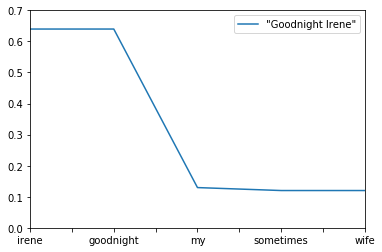

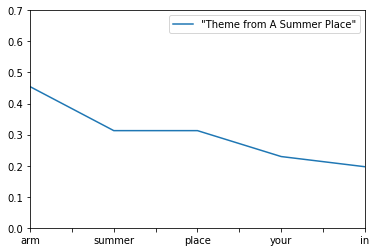

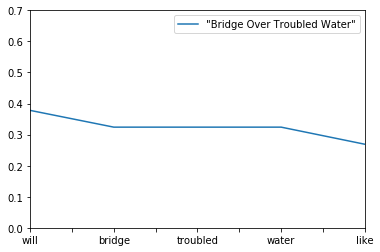

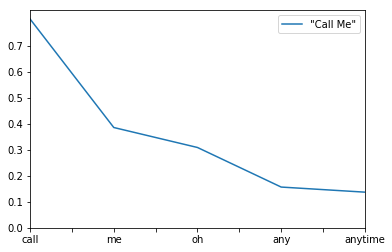

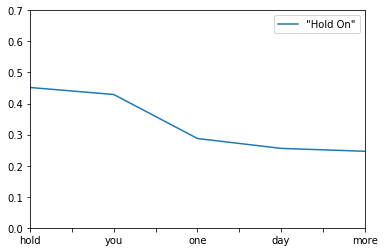

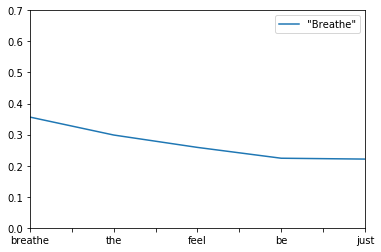

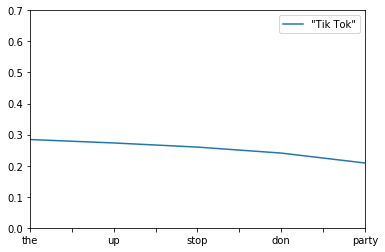

In [390]:
for i in np.arange(len(music)):
    common[i][:5].plot(label=music["Song"][i], legend=True, yticks=np.arange(8)/10)
    plt.show()
#Greater word variety in modern age. Less repetitive.

# Sentiment Analysis
Overwhelmingly neutral sentences with the neutral sentences taking up a greater portion of the text in recent years.
Amount of positive sentiments is stable over the years except for 2000. Negative sentiments seem to swing wildly between more and less but in general has an upward trend.

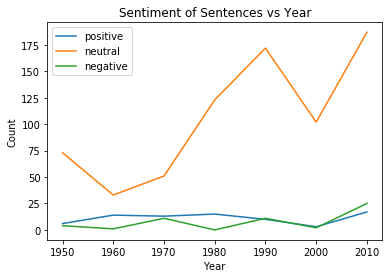

In [278]:
for sentiment in sentiments:
    plt.plot(music["Year"], sentiment_summary[sentiment], label=sentiment)
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Sentiment of Sentences vs Year");
plt.legend();
#plt.savefig("sentvsyear.tiff")

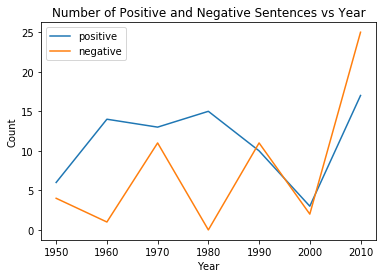

In [279]:
plt.plot(music["Year"], sentiment_summary[sentiments[0]], label=sentiments[0])
plt.plot(music["Year"], sentiment_summary[sentiments[2]], label=sentiments[2])
plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Number of Positive and Negative Sentences vs Year");
plt.legend();
#plt.savefig("posnegvsyear.tiff")

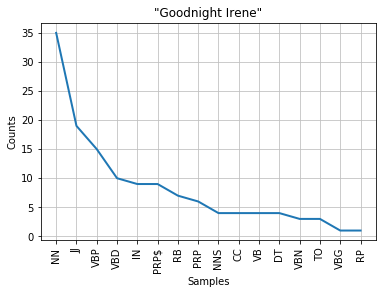

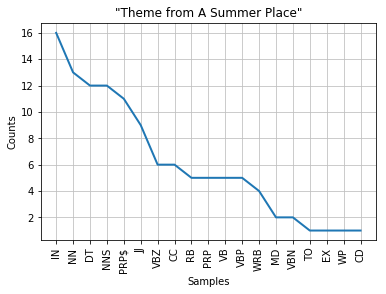

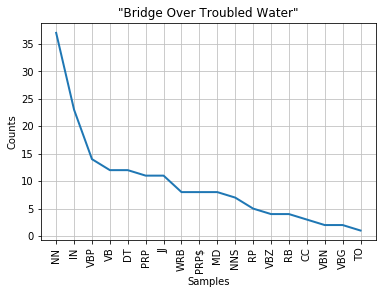

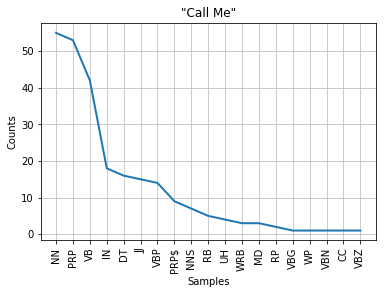

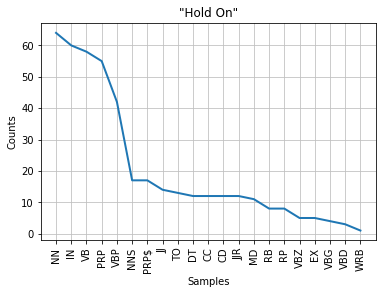

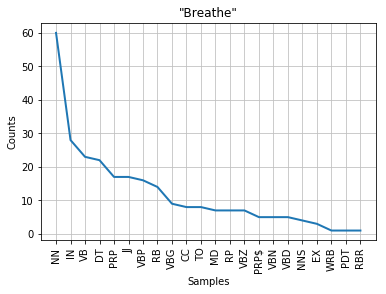

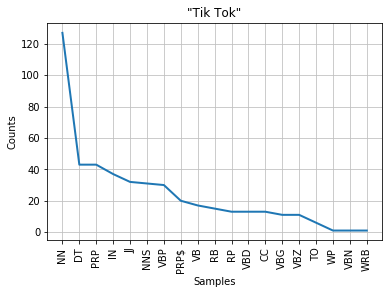

In [304]:
for i in np.arange(len(music)):
    songs_freq[i].plot(cumulative=False, title=music["Song"][i])

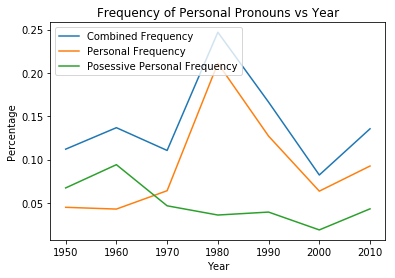

In [281]:
plt.plot(music["Year"], music["Personal Frequency"], label="Combined Frequency")
plt.plot(music["Year"], prp_freq, label="Personal Frequency")
plt.plot(music["Year"], prpp_freq, label="Posessive Personal Frequency")
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.title("Frequency of Personal Pronouns vs Year")
plt.legend(loc="upper left");
#plt.savefig("ppvsyear.tiff")

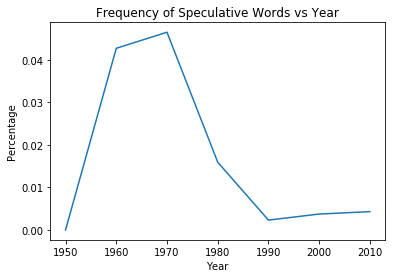

In [282]:
plt.plot(music["Year"], spec_freq)
plt.ylabel("Percentage")
plt.xlabel("Year")
plt.title("Frequency of Speculative Words vs Year");
#plt.savefig("specvsyear.tiff")

Text(0.5, 1.0, 'Words vs Year')

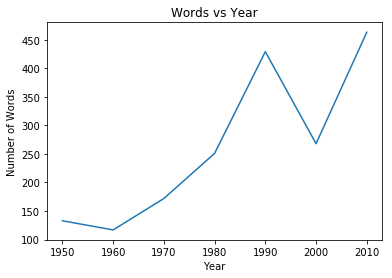

In [283]:
plt.plot(music["Year"], music["Word Count"], label="Words")
plt.ylabel("Number of Words")
plt.xlabel("Year")
plt.title("Words vs Year")
#plt.savefig("wordsvsyear.tiff")

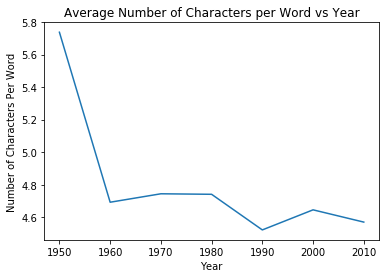

In [284]:
plt.plot(music["Year"], music["Character Count"]/music["Word Count"], label="Characters")
plt.ylabel("Number of Characters Per Word")
plt.xlabel("Year")
plt.title("Average Number of Characters per Word vs Year");
#plt.savefig("avgvsyear.tiff")